<a href="https://colab.research.google.com/github/AlejoRMinetti/keras-scikit-examples/blob/main/11_Clasificacion_Binaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![texto alternativo](https://drive.google.com/uc?id=1_ZoJOp39dxsRTVndJP1_7jdY7oGi8sSu) 

<h1><center>Redes Neuronales con Keras y Scikit</center></h1>


<center><i>Clasificación binaria: Predicting Red Hat Business Value</i></center>

# <h1>Contenido</h1>

<div class="alert alert-block alert-warning" style="margin-top: 20px">
    <ol>
        <li><a href="#problema">Contexto Analítico</a></li>   
        <li><a href="#ingenieria">Ingeniería de datos</a></li>          
        <li><a href="#arquitectura">Arquitectura propuesta</a></li>
        <li><a href="#evaluaion">Evaluación del Modelo</a></li>
    </ol>
</div>
<br>
<hr>

# <h1 id="problema">Contexto analítico</h1>

Este caso se basa en un reto propuesto por Red Hat en la plataforma Kaggle. (https://www.kaggle.com/c/predicting-red-hat-business-value/data) 

Red Hat es capaz de obtener una importante cantidad de información de comportamiento de sus clientes. El interes de la compañia se basa en la busqueda de mejores metodos para analizar sus clientes para predecir sobre cuales deberian hacer un especial enfasis que podrian convertirse en clientes de alto valor.

En este reto se propone crear un algoritmo de clasificación que identifique los clientes con mayor potencial para convertirse en clientes de alto valor para Red Hat basados en su actividad.

Se cuenta con dos datasets (people.csv y act_train.csv) los cuales cargaremos directamente a Colab.


In [ ]:
#Importamos las librerias necesarias
import pandas as pd
import numpy as np
import io
from google.colab import files #Librería necesaria para interactuar con archivos en Colab

In [ ]:
#Cargamos los dataset
#uploaded = files.upload()
#people = pd.read_csv(io.StringIO(uploaded['people.csv'].decode('utf-8')), sep = ',' )
people = pd.read_csv('people.csv', sep = ',' )
people.head(3)

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,type 2,type 4,False,False,True,True,False,False,False,True,False,False,False,False,False,True,False,True,True,True,False,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,type 2,type 2,True,True,True,True,True,True,False,True,False,True,False,True,True,True,True,True,True,True,True,False,False,True,True,True,True,False,True,True,99


El primer hecho a resaltar es que la información se presenta anonimizada, algo muy común en la ciencia de datos. 

Se aprecia una gran cantidad de campos de naturaleza categórica. 



In [ ]:
#uploaded1 = files.upload()
#activity = pd.read_csv(io.StringIO(uploaded1['act_train.csv'].decode('utf-8')), sep = ',' )
activity = pd.read_csv('act_train.csv', sep = ',' )
activity.head(3)

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


# <h1 id="ingenieria">Ingeniería de datos</h1>

Evaluaremos ahora el tamaño de los datasets y la completitud de información en las distintas variables disponibles.

In [ ]:
print(people.shape)
100*people.isnull().sum()/people.shape[0]

In [ ]:
#Repetimos el procedimiento con el dataset de activity
print(activity.shape)
100*activity.isnull().sum()/activity.shape[0]

Se evidencia que los campos char_1 al char_9 tienen el 92% de sus valores en nulo Esta cantidad es muy elevada para aplicar metodos de imputación, por lo cual optaremos por elminar las columnas con este inconveniente.

In [ ]:
activity.columns

Index(['people_id', 'activity_id', 'date', 'activity_category', 'char_1',
       'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7', 'char_8',
       'char_9', 'char_10', 'outcome'],
      dtype='object')

In [ ]:
activity.drop(columns=['char_1','char_2', 'char_3', 'char_4', 'char_5', 'char_6',\
                       'char_7', 'char_8','char_9'],inplace=True)
print(activity.shape)
activity.head(3)

(2197291, 6)


,people_id,activity_id,date,activity_category,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,type 1,0


Para consolidar un dataset debemos tener un par de consideraciones previas: 

* Se aprecia que existen dos variables que tienen los mismos nombres en ambos 
datasets (char_2 y char_10) por lo cual es buena practica renombrar estas columnas para evitar confusiones al momento de unificar las fuentes.
* En el caso de la variable categórica "tipo_actividad" existe una proporción de nulos que podemos reemplazar por la moda.



In [ ]:
#Renombramos columnas
activity = activity.rename(columns={"date":"fecha_actividad","char_10":"tipo_actividad"})
#Reenplazamos el tipo de actividad por la moda 
activity["tipo_actividad"] = activity["tipo_actividad"].fillna(activity["tipo_actividad"].mode()[0])
#Verificamos el cambio
100*activity.isnull().sum()/activity.shape[0]

people_id            0.0
activity_id          0.0
fecha_actividad      0.0
activity_category    0.0
tipo_actividad       0.0
outcome              0.0
dtype: float64

Ahora unificamos los datasets empleando la función merge y evaluamos la consistencia luego de esta operación 

In [ ]:
consolidado = activity.merge(people,on=["people_id"],how="inner")
print("Tamaño previo: ",activity.shape)
print("Nuevo tamaño: ",consolidado.shape)

Tamaño previo:  (2197291, 6)
Nuevo tamaño:  (2197291, 46)


La variable objetivo que clasifica la actividad de los usuarios como potenciales clientes es denominada "outcome", evaluaremos la distribución de este variable: 

In [ ]:
print("Distribución de outcome: \n", 100*consolidado["outcome"].value_counts()/consolidado.shape[0])

Distribución de outcome: 
 0    55.60456
1    44.39544
Name: outcome, dtype: float64


Como lo hemos mencionado, las redes neuronales requieren de entrada sólo valores numericos, por lo cual debemos convertir aquellas que no lo son. El dataset consolidado cuenta con 46 variables de tipo booleanas, numericas o categóricas que deben ser transformadas.

In [ ]:
types = pd.DataFrame(consolidado.dtypes)
print("Tipos de variables",types.groupby(0).size())

consolidado = consolidado.replace({False: 0, True: 1})

types = pd.DataFrame(consolidado.dtypes)
print("Tipos de variables luego de reemplazo",types.groupby(0).size())

Tipos de variables 0
bool      28
int64      2
object    16
dtype: int64
Tipos de variables luego de reemplazo 0
int64     30
object    16
dtype: int64


Si recordamos, el identificador people_id se compone por un prefijo "ppl_" seguido de un número único por usuario.En este caso basta con recortar el prefijo para transformar esta variable en numerica.

In [ ]:
consolidado.people_id = consolidado.people_id.str.slice(start=4).astype(float).astype(int)

types = pd.DataFrame(consolidado.dtypes)
print("Tipos de variables luego de 2do reemplazo",types.groupby(0).size())

Tipos de variables luego de 2do reemplazo 0
int64     31
object    15
dtype: int64


Al validar el dataset consolidado podemos aplicar la misma metodología previamente mencionada a otro par de columnas: 

"activity_id", "activity_category", "group_1", "tipo_actividad"

In [ ]:
consolidado[["activity_id", "activity_category", "group_1", "tipo_actividad"]].head(3)

,activity_id,activity_category,group_1,tipo_actividad
0,act2_1734928,type 4,group 17304,type 76
1,act2_2434093,type 2,group 17304,type 1
2,act2_3404049,type 2,group 17304,type 1


In [ ]:
consolidado.activity_id = consolidado.activity_id.str.slice(start=5).astype(float).astype(int)
consolidado.activity_category = consolidado.activity_category.str.slice(start=5).astype(float).astype(int)
consolidado.group_1 = consolidado.group_1.str.slice(start=6).astype(float).astype(int)
consolidado.tipo_actividad = consolidado.tipo_actividad.str.slice(start=5).astype(float).astype(int)

types = pd.DataFrame(consolidado.dtypes)
print("Tipos de variables luego de 3er reemplazo",types.groupby(0).size())

Tipos de variables luego de 3er reemplazo 0
int64     35
object    11
dtype: int64


Evaluemos las variables que siguen tipo object y la cantidad de valores distintos que poseen

In [ ]:
categoricas = types.index[types[0] == 'O'].values
for line in categoricas:
 print("La variable "+ line +" contiene:",str(len(consolidado[line].unique()))+" distinct values")

La variable fecha_actividad contiene: 411 distinct values
La variable char_1 contiene: 2 distinct values
La variable char_2 contiene: 3 distinct values
La variable date contiene: 1196 distinct values
La variable char_3 contiene: 43 distinct values
La variable char_4 contiene: 25 distinct values
La variable char_5 contiene: 9 distinct values
La variable char_6 contiene: 7 distinct values
La variable char_7 contiene: 25 distinct values
La variable char_8 contiene: 8 distinct values
La variable char_9 contiene: 9 distinct values


Del listado anterior resaltamos dos variables tipo fecha ("date", "fecha_actividad") Para la red neuronal representa una oportunidad poder extraer una serie de caracteristicas adicionales que le permitan entender patrones estacionales de diferentes periodicidades (diario, semanal, mensual, etc) es por esto que crearemos una serie de variables adicionales (de naturaleza numérica) a partir de estas dos fechas:

In [ ]:
#Convertimos la variable objeto en datetime
consolidado["date"] = pd.to_datetime(consolidado["date"])
#Creamos nuevas variables
consolidado["dia"] = consolidado["date"].dt.day
consolidado["dia_semana"] = consolidado["date"].dt.weekday
consolidado["semana"] = consolidado["date"].dt.week
consolidado["mes"] = consolidado["date"].dt.month
consolidado["trimestre"] = consolidado["date"].dt.quarter
consolidado["año"] = consolidado["date"].dt.year

#Repetimos el procedimiento anterior con fecha_actividad
consolidado["fecha_actividad"] = pd.to_datetime(consolidado["fecha_actividad"])
consolidado["dia_actividad"] = consolidado["fecha_actividad"].dt.day
consolidado["dia_semana_actividad"] = consolidado["fecha_actividad"].dt.weekday
consolidado["semana_actividad"] = consolidado["fecha_actividad"].dt.week
consolidado["mes_actividad"] = consolidado["fecha_actividad"].dt.month
consolidado["trimestre_actividad"] = consolidado["fecha_actividad"].dt.quarter
consolidado["año_actividad"] = consolidado["fecha_actividad"].dt.year

#Delete the original date columns
del(consolidado["date"])
del(consolidado["fecha_actividad"])

types = pd.DataFrame(consolidado.dtypes)
print("Tipos de variables luego de 4to reemplazo",types.groupby(0).size())

Tipos de variables luego de 4to reemplazo 0
int64     47
object     9
dtype: int64


In [ ]:
consolidado.head(3)

,people_id,activity_id,activity_category,tipo_actividad,outcome,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,dia,dia_semana,semana,mes,trimestre,año,dia_actividad,dia_semana_actividad,semana_actividad,mes_actividad,trimestre_actividad,año_actividad
0,100,1734928,4,76,0,type 2,17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,29,1,26,6,2,2021,26,5,34,8,3,2023
1,100,2434093,2,1,0,type 2,17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,29,1,26,6,2,2021,27,1,39,9,3,2022
2,100,3404049,2,1,0,type 2,17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,29,1,26,6,2,2021,27,1,39,9,3,2022


Con la relativa pequeña cantidad de variables categoricas que manejamos vamos a proceder a realizar la conversión por One Hot Encoding

In [ ]:
categoricas = types.index[types[0] == 'O'].values
for line in categoricas:
 print("La variable "+ line +" contiene:",str(len(consolidado[line].unique()))+" distinct values")

La variable char_1 contiene: 2 distinct values
La variable char_2 contiene: 3 distinct values
La variable char_3 contiene: 43 distinct values
La variable char_4 contiene: 25 distinct values
La variable char_5 contiene: 9 distinct values
La variable char_6 contiene: 7 distinct values
La variable char_7 contiene: 25 distinct values
La variable char_8 contiene: 8 distinct values
La variable char_9 contiene: 9 distinct values


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

columna='char_6'
le = LabelEncoder()
le_ajustado=le.fit_transform(consolidado[columna]).reshape(-1,1)
le_ajustado[:10]

In [ ]:
encoder = OneHotEncoder(sparse=False)
column = [columna+ "_"+ str(i) for i in le.classes_]
column

['char_6_type 1',
 'char_6_type 2',
 'char_6_type 3',
 'char_6_type 4',
 'char_6_type 5',
 'char_6_type 6',
 'char_6_type 7']

In [ ]:
pd.DataFrame(encoder.fit_transform(le_ajustado),columns =column).head(10)

,char_6_type 1,char_6_type 2,char_6_type 3,char_6_type 4,char_6_type 5,char_6_type 6,char_6_type 7
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Se define función que captura el dataframe y la columna para retornar un dataframe luego de OHE
def crea_OneHotEncoding(df, columna):
  le = LabelEncoder()
  le_ajustado=le.fit_transform(df[columna]).reshape(-1,1)
  encoder = OneHotEncoder(sparse=False)
  column = [columna+ "_"+ str(i) for i in le.classes_]
  data = encoder.fit_transform(le_ajustado)
  return(pd.DataFrame(data,columns =column))

In [ ]:
numeric_columns = list(set(types.index[types[0] =="int64"].values) - set(["outcome"]))
variables_consolidadas = consolidado[numeric_columns]
objetivo = consolidado["outcome"]

categoricas = types.index[types[0] == 'O'].values
for column in categoricas:
  df = crea_OneHotEncoding(consolidado,column)
  variables_consolidadas = pd.concat([variables_consolidadas,df],axis=1)
  print("Columna ",column, " transformada!")

print("Tamaño final del dataset transformado:",variables_consolidadas.shape)

Columna  char_1  transformada!
Columna  char_2  transformada!
Columna  char_3  transformada!
Columna  char_4  transformada!
Columna  char_5  transformada!
Columna  char_6  transformada!
Columna  char_7  transformada!
Columna  char_8  transformada!
Columna  char_9  transformada!
Tamaño final del dataset transformado: (2197291, 177)


In [ ]:
variables_consolidadas.head(3)

,char_11,char_17,char_31,char_36,dia,semana,trimestre,char_14,char_15,char_23,char_22,char_34,activity_id,tipo_actividad,char_25,dia_semana,char_21,dia_actividad,char_19,año,año_actividad,activity_category,semana_actividad,trimestre_actividad,group_1,char_12,char_32,char_24,mes_actividad,char_35,char_26,char_27,char_30,char_33,dia_semana_actividad,char_37,char_28,char_29,char_38,char_16,...,char_7_type 11,char_7_type 12,char_7_type 13,char_7_type 14,char_7_type 15,char_7_type 16,char_7_type 17,char_7_type 18,char_7_type 19,char_7_type 2,char_7_type 20,char_7_type 21,char_7_type 22,char_7_type 23,char_7_type 24,char_7_type 25,char_7_type 3,char_7_type 4,char_7_type 5,char_7_type 6,char_7_type 7,char_7_type 8,char_7_type 9,char_8_type 1,char_8_type 2,char_8_type 3,char_8_type 4,char_8_type 5,char_8_type 6,char_8_type 7,char_8_type 8,char_9_type 1,char_9_type 2,char_9_type 3,char_9_type 4,char_9_type 5,char_9_type 6,char_9_type 7,char_9_type 8,char_9_type 9
0,0,0,1,1,29,26,2,1,0,0,0,1,1734928,76,0,1,1,26,0,2021,2023,4,34,3,17304,0,0,0,8,1,0,1,1,0,5,0,1,0,36,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,1,29,26,2,1,0,0,0,1,2434093,1,0,1,1,27,0,2021,2022,2,39,3,17304,0,0,0,9,1,0,1,1,0,1,0,1,0,36,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,1,1,29,26,2,1,0,0,0,1,3404049,1,0,1,1,27,0,2021,2022,2,39,3,17304,0,0,0,9,1,0,1,1,0,1,0,1,0,36,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Con el dataset ya consolidado procedemos a seleccionar las muestras de entrenamiento, validación y prueba

In [ ]:
from sklearn.model_selection import train_test_split
#Entrenamiento y prueba con relación 80:20
x_train, x_test, y_train, y_test = train_test_split(variables_consolidadas,objetivo, test_size=0.2,random_state=2020)
#Entrenamiento y validación con relación 90:10
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.1, random_state=2020)

print("Shape of x_train:",x_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)
print("Shape of y_val:",y_val.shape)

Shape of x_train: (1582048, 177)
Shape of x_test: (439459, 177)
Shape of x_val: (175784, 177)
Shape of y_train: (1582048,)
Shape of y_test: (439459,)
Shape of y_val: (175784,)


# <h1 id="arquitectura">Arquitectura Propuesta</h1>

Una vez consolidado los sets de información de entrenamiento, validacion y pruebas ya podemos iniciar a modelar nuestra red neuronal con las siguientes consideraciones:
* Debido a que el problema consiste en un clasificador binario la función de perdidas más recomendada es "binary_crossentropy".
* De manera similar una función de activación que se adecua al tipo de problema es la "sigmoid".
* La metrica para evaluación sera la precisión "accuracy"
* Debido a la gran cantidad de información el entrenamiento tomara más tiempo, en este escenario se implementaran arquitecturas más pequeñas con pocas epocas de entrenamiento y se escalará el modelo a medida los resultados del accuracy mejoren.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

#Red neuronal pequeña
model = Sequential()
model.add(Dense(256,input_dim = x_train.shape[1],activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid")) 
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               45568     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 111,617
Trainable params: 111,617
Non-trainable params: 0
_________________________________________________________________
None


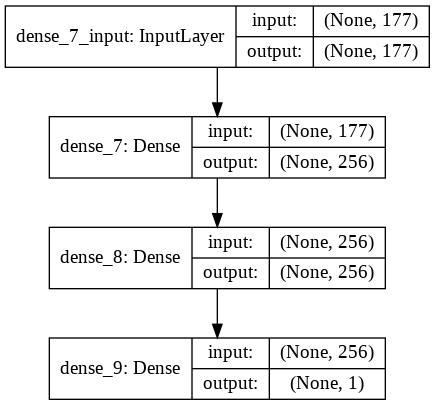

In [ ]:
plot_model(model, to_file='model.png',show_shapes=True)

In [ ]:
model.fit(x_train,y_train, validation_data = (x_val,y_val),epochs=3, batch_size=64)

Train on 1582048 samples, validate on 175784 samples
Epoch 1/3
1582048/1582048 [==============================] - 119s 75us/step - loss: 7.1552 - acc: 0.5561 - val_loss: 7.1357 - val_acc: 0.5573
Epoch 2/3
1582048/1582048 [==============================] - 117s 74us/step - loss: 7.1552 - acc: 0.5561 - val_loss: 7.1357 - val_acc: 0.5573
Epoch 3/3
1582048/1582048 [==============================] - 118s 74us/step - loss: 7.1552 - acc: 0.5561 - val_loss: 7.1357 - val_acc: 0.5573


In [ ]:
#Red neuronal de 2 capas
model = Sequential()
model.add(Dense(512,input_dim = x_train.shape[1],activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(x_train,y_train, validation_data = (x_val,y_val),epochs=3, batch_size=64)

Train on 1582048 samples, validate on 175784 samples
Epoch 1/3
1582048/1582048 [==============================] - 130s 82us/step - loss: 7.1558 - acc: 0.5560 - val_loss: 7.1357 - val_acc: 0.5573
Epoch 2/3
1582048/1582048 [==============================] - 129s 82us/step - loss: 7.1552 - acc: 0.5561 - val_loss: 7.1357 - val_acc: 0.5573
Epoch 3/3
1582048/1582048 [==============================] - 130s 82us/step - loss: 7.1552 - acc: 0.5561 - val_loss: 7.1357 - val_acc: 0.5573


A pesar de haber escalado el tamaño de la red los resultados siguen siendo descepcionantes. En este caso el mejor paso a seguir es volver a validar los datos disponibles. En este punto existen dos opciones a explorar: 
* Estandarizar las variables numericas disponibles.
* Volver a realizar el One Hot Encoding.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [ ]:
#Red neuronal de 2 capas
model = Sequential()
model.add(Dense(512,input_dim = x_train_scaled.shape[1],activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(x_train_scaled,y_train, validation_data = (x_val_scaled,y_val),epochs=3, batch_size=64)

Train on 1582048 samples, validate on 175784 samples
Epoch 1/3
1582048/1582048 [==============================] - 132s 83us/step - loss: 0.1988 - acc: 0.9122 - val_loss: 0.1405 - val_acc: 0.9411
Epoch 2/3
1582048/1582048 [==============================] - 130s 82us/step - loss: 0.1194 - acc: 0.9515 - val_loss: 0.1106 - val_acc: 0.9561
Epoch 3/3
1582048/1582048 [==============================] - 129s 82us/step - loss: 0.0929 - acc: 0.9634 - val_loss: 0.0933 - val_acc: 0.9650


Con sólo la estandarización de la información el desempeño del modelo ha mejorado drasticamente logrando una precision del 96%! Podriamos seguir evaluanto redes más grandes, pero es un valor aceptable para nosotros por el momento. El siguiente paso es probar este mismo modelo con información que la red nunca haya visto (set de prueba)

In [ ]:
result = model.evaluate(x_test_scaled,y_test)
for i in range(len(model.metrics_names)):
 print("Metric ",model.metrics_names[i],":",
str(round(result[i],2)))

439459/439459 [==============================] - 21s 48us/step
Metric  loss : 0.09
Metric  acc : 0.96


El desempeño con el set de prueba sigue siendo bueno por lo cual ya podemos emplear la arquitectura definida y realizar un entrenamiento con un mayor número de epocas.

In [ ]:
model = Sequential()
model.add(Dense(512,input_dim = x_train_scaled.shape[1],activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(x_train_scaled,y_train, validation_data = (x_val_scaled,y_val),epochs=12, batch_size=64)

Train on 1582048 samples, validate on 175784 samples
Epoch 1/12
1582048/1582048 [==============================] - 131s 83us/step - loss: 0.1972 - acc: 0.9129 - val_loss: 0.1430 - val_acc: 0.9409
Epoch 2/12
1582048/1582048 [==============================] - 130s 82us/step - loss: 0.1188 - acc: 0.9518 - val_loss: 0.1088 - val_acc: 0.9571
Epoch 3/12
1582048/1582048 [==============================] - 129s 82us/step - loss: 0.0927 - acc: 0.9636 - val_loss: 0.0898 - val_acc: 0.9652
Epoch 4/12
1582048/1582048 [==============================] - 130s 82us/step - loss: 0.0780 - acc: 0.9697 - val_loss: 0.0831 - val_acc: 0.9688
Epoch 5/12
1582048/1582048 [==============================] - 129s 82us/step - loss: 0.0689 - acc: 0.9735 - val_loss: 0.0781 - val_acc: 0.9717
Epoch 6/12
1582048/1582048 [==============================] - 130s 82us/step - loss: 0.0624 - acc: 0.9766 - val_loss: 0.0746 - val_acc: 0.9737
Epoch 7/12
1582048/1582048 [==============================] - 129s 82us/step - loss: 0.05

# <h1 id="evaluacion">Evaluación del modelo</h1>

La red ha logrado mejorar un poco su desempeño con más epocas de entrenamiento. Finalmente vamos a evaluar gráficamente el desempeño de la función de pérdidas y la presición a traves de cada época de entrenamiento con el fin de validar algun posible sobre-entrenamiento.

In [ ]:
result = model.evaluate(x_test_scaled,y_test)
for i in range(len(model.metrics_names)):
 print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

439459/439459 [==============================] - 20s 47us/step
Metric  loss : 0.07
Metric  acc : 0.98


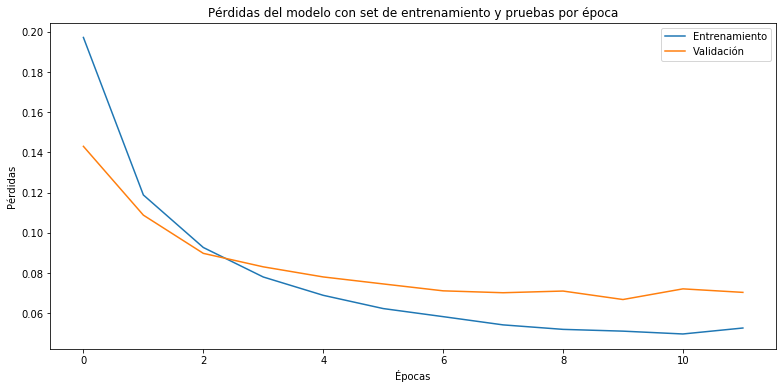

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(13,6))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title("Pérdidas del modelo con set de entrenamiento y pruebas por época")
plt.ylabel('Pérdidas')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

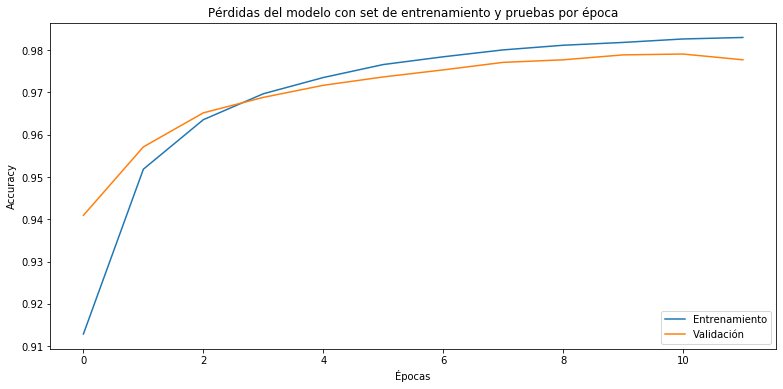

In [ ]:
plt.figure(figsize=(13,6))
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title("Pérdidas del modelo con set de entrenamiento y pruebas por época")
plt.ylabel('Accuracy')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
plt.show()

**Happy Coding!**